## S456 FC SCM Baseline

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-03 14:45:33.117123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 14:45:34.625138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 14:45:36.899779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *


## Specify connectome and transcriptome

Assign features and targets

In [4]:
# S400
X = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=True, hemisphere='left', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=True, measure='SC', hemisphere='left', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=True, measure='FC', hemisphere='left', include_labels=True)
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]

Number of components for 95% variance PCA: 27


In [5]:
Y_sc = Y_sc[valid_indices][:, valid_indices]
Y_fc = Y_fc[valid_indices][:, valid_indices]


# Filter hemisphere indices to only include valid indices
left_coords = coords[lh_indices]
rh_indices_valid = [i for i in rh_indices if i != 444]
right_coords = coords[rh_indices_valid]

#coords = coords[valid_indices]

print(f"Transcriptome data shape (regions x genes): {X.shape}")
print(f"Connectivity matrix shape (regions x regions): {Y_fc.shape}")
print(f"Coordinates shape (regions x 3): {coords.shape}")
print(f"Left hemisphere coordinates shape (regions x 3): {left_coords.shape}")
print(f"Right hemisphere coordinates shape (regions x 3): {right_coords.shape}")

Y = Y_fc


Transcriptome data shape (regions x genes): (200, 27)
Connectivity matrix shape (regions x regions): (200, 200)
Coordinates shape (regions x 3): (400, 3)
Left hemisphere coordinates shape (regions x 3): (200, 3)
Right hemisphere coordinates shape (regions x 3): (200, 3)


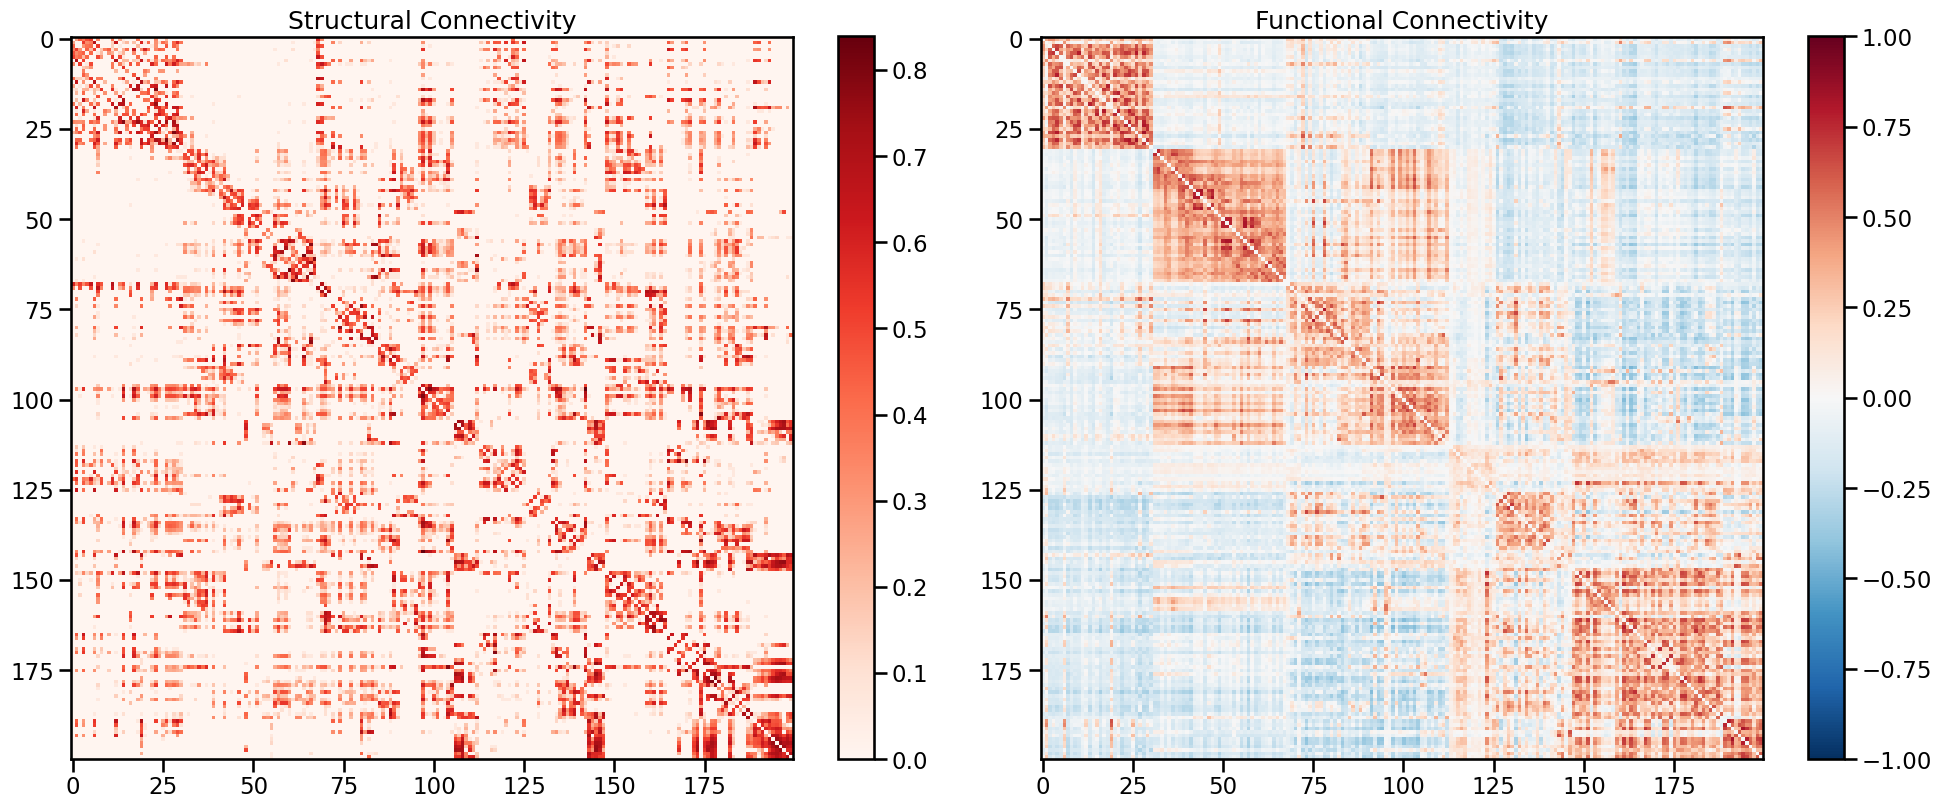

In [6]:
# Visualize structural and functional connectivity matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

im1 = ax1.imshow(Y_sc, cmap='Reds')
ax1.set_title('Structural Connectivity')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(Y_fc, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Functional Connectivity') 
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()


## Fit SCM model

In [7]:
# Adapted from https://github.com/kpisti/SCM/tree/v1.0. Below implementation is aligned with Ridge Regression model from full paper.
def fit_scm(X, Y, alpha=0.0, verbose=True):
    """
    Fit Structural Covariance Model (SCM) to predict connectivity from gene expression.
    
    Args:
        X: Gene expression PCA matrix (regions x gene_PCA_dim)
        Y: Connectivity matrix (regions x regions) 
        alpha: Regularization parameter for ridge regression
        
    Returns:
        O: Estimated rule matrix (gene_PCA_dim x gene_PCA_dim)
        Y_pred: Predicted connectivity matrix (regions x regions)
        objective: Objective function value
    """
    # Check memory requirements before proceeding
    if verbose:
        print(f"X shape: {X.shape}")
        # Calculate memory needed for Kronecker product
        kron_size = (X.shape[0]**2) * (X.shape[1]**2) * 8  # 8 bytes per float64
        available_mem = psutil.virtual_memory().available
        if kron_size > available_mem:
            raise MemoryError(f"Kronecker product would require {kron_size/1e9:.2f}GB but only {available_mem/1e9:.2f}GB available")
    
    # Compute Kronecker product of X with itself to obtain K matrix
    K = np.kron(X, X)  
    if verbose: print(f"K shape after Kronecker: {K.shape}")
    
    # Flatten connectivity matrix Y
    if verbose: print(f"Y shape before flatten: {Y.shape}")
    Y_flat = Y.flatten() 
    if verbose: print(f"Y_flat shape: {Y_flat.shape}")
    
    # Compute K transpose multiplied by K
    K_transpose_K = np.dot(K.T, K) 
    if verbose: print(f"K_transpose_K shape: {K_transpose_K.shape}")
    
    # Add regularization term
    # K_transpose_K /= np.linalg.norm(K_transpose_K)
    K_reg = K_transpose_K + alpha * np.identity(K_transpose_K.shape[0]) 
    if verbose: print(f"K_reg shape: {K_reg.shape}")

    # Compute the pseudo-inverse solution
    K_pseudo_inv = np.linalg.pinv(K_reg).dot(K.T)
    if verbose: print(f"K_pseudo_inv shape: {K_pseudo_inv.shape}")
    
    # Estimate the rule matrix in vectorized form
    O_flat = K_pseudo_inv.dot(Y_flat)
    if verbose: print(f"O_flat shape: {O_flat.shape}")
    
    # Compute residuals and objective
    residuals = Y_flat - np.dot(K, O_flat)
    if verbose: print(f"Residuals shape: {residuals.shape}")
    residual_norm = np.linalg.norm(residuals)

    K_proj = np.dot(K, K_pseudo_inv)
    if verbose: print(f"K_proj shape: {K_proj.shape}")
    
    tau = np.trace(np.identity(K_proj.shape[0]) - K_proj)
    if verbose: print(f"tau: {tau}")
    
    objective = residual_norm*residual_norm/tau/tau # ** 2)
    if verbose: print(f"objective: {objective}")
    
    # Reshape O to original dimensions
    O = O_flat.reshape(X.shape[1], X.shape[1])
    
    # Predict connectivity matrix
    Y_pred = np.dot(X, np.dot(O, X.T))
    
    # Min-max scale Y_pred to [-1,1] range
    return O, Y_pred, objective

# Fit the default unregularized model
O, Y_pred, objective = fit_scm(X, Y)

X shape: (200, 27)
K shape after Kronecker: (40000, 729)
Y shape before flatten: (200, 200)
Y_flat shape: (40000,)
K_transpose_K shape: (729, 729)
K_reg shape: (729, 729)
K_pseudo_inv shape: (729, 40000)
O_flat shape: (729,)
Residuals shape: (40000,)
K_proj shape: (40000, 40000)
tau: 39271.00000000001
objective: 6.626297453033628e-07


In [8]:
'''
def grid_search_alpha(X, Y, alpha_values):
    objectives = []
    for alpha in alpha_values:
        _, _, obj = fit_scm(X, Y, alpha=alpha, verbose=False)
        print(alpha, '-',  obj)
        objectives.append(obj)
    
    # Plot alpha vs objective
    plt.figure(figsize=(8, 6))
    plt.plot(alpha_values, objectives, 'bo-')
    plt.xscale('symlog', linthresh=0.01)  # Log scale that handles 0
    plt.xlabel('Alpha')
    plt.ylabel('Objective Value') 
    plt.title('SCM Model Objective vs Alpha')
    plt.grid(True)
    plt.show()
    
    return alpha_values, objectives

# Run grid search
#alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alphas = [0, 0.001, 0.01, 0.1, 1, 10, 10**2, 10**3]
alpha_values, objectives = grid_search_alpha(X, Y, alphas)
'''

"\ndef grid_search_alpha(X, Y, alpha_values):\n    objectives = []\n    for alpha in alpha_values:\n        _, _, obj = fit_scm(X, Y, alpha=alpha, verbose=False)\n        print(alpha, '-',  obj)\n        objectives.append(obj)\n    \n    # Plot alpha vs objective\n    plt.figure(figsize=(8, 6))\n    plt.plot(alpha_values, objectives, 'bo-')\n    plt.xscale('symlog', linthresh=0.01)  # Log scale that handles 0\n    plt.xlabel('Alpha')\n    plt.ylabel('Objective Value') \n    plt.title('SCM Model Objective vs Alpha')\n    plt.grid(True)\n    plt.show()\n    \n    return alpha_values, objectives\n\n# Run grid search\n#alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]\nalphas = [0, 0.001, 0.01, 0.1, 1, 10, 10**2, 10**3]\nalpha_values, objectives = grid_search_alpha(X, Y, alphas)\n"


SCM model metrics:
Pearson r: 0.637
R-squared: 0.40531
MSE: 0.02555


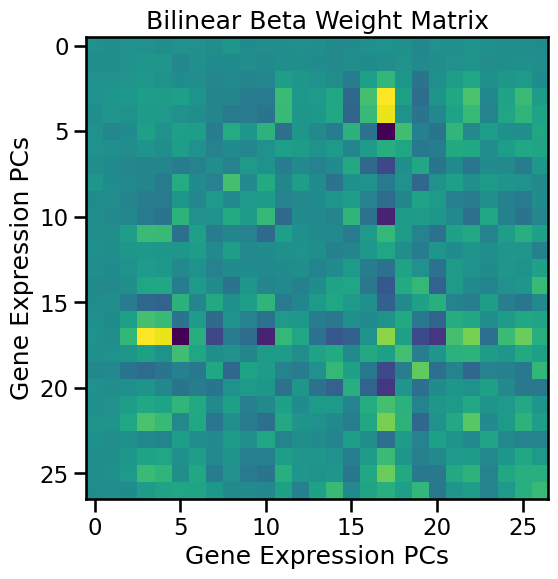

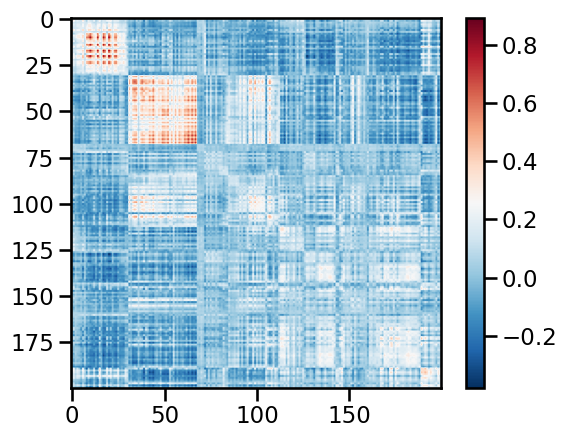

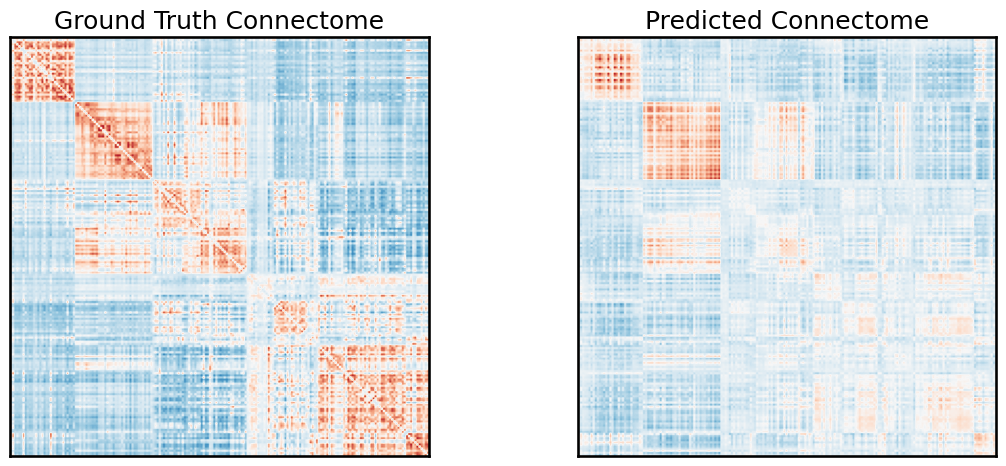

In [9]:

# Flatten matrices for calculations
y_true = Y.flatten()
y_pred = Y_pred.flatten()

# Metrics
pearson_r, _ = stats.pearsonr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print("\nSCM model metrics:")
print(f"Pearson r: {pearson_r:.3f}")
print(f"R-squared: {r2:.5f}") 
print(f"MSE: {mse:.5f}")

plt.figure(figsize=(8, 6))
plt.imshow(O)
#plt.colorbar(label='Beta Weight')
plt.title('Bilinear Beta Weight Matrix')
plt.xlabel('Gene Expression PCs')
plt.ylabel('Gene Expression PCs') 
plt.show()

im = plt.imshow(Y_pred, cmap='RdBu_r')
plt.colorbar(im)
plt.show()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax1.set_title('Ground Truth Connectome')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax2.set_title('Predicted Connectome')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()


permutation 100 of 100
hemisphere:  left
rotated_ids shape: (200, 100)
permutation: 0
permutation: 50


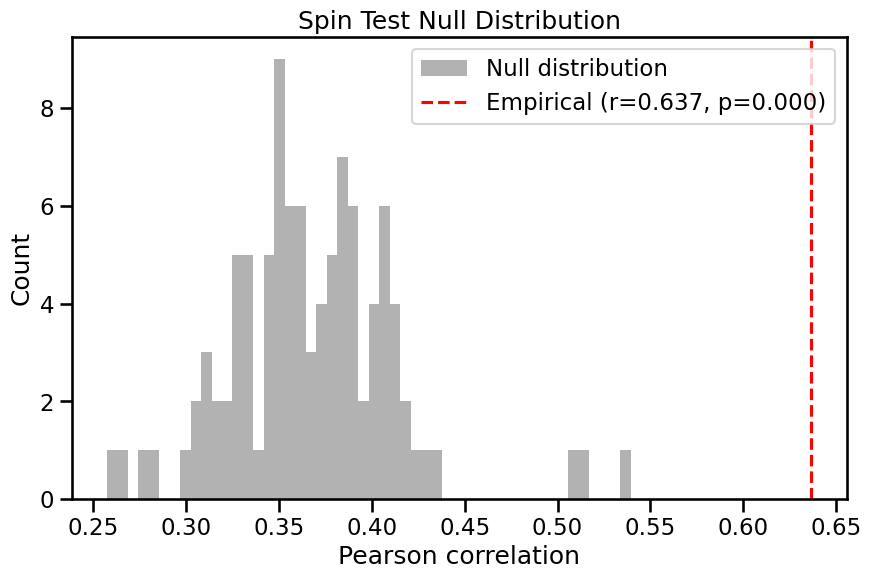

In [10]:
def run_spin_test(X, Y_true, left_coords, right_coords, hemisphere, n_perms=100, shuffle_target=True):
    """
    Run spin test permutation analysis for SCM model
    
    Parameters:
    -----------
    X : array-like of shape (n_samples, n_features)
        Input transcriptome data
    Y_true : array-like of shape (n_samples, n_samples) 
        Input connectome data
    left_coords : array-like
        Left hemisphere coordinates
    right_coords : array-like  
        Right hemisphere coordinates
    n_perms : int, default=100
        Number of permutations for null distribution
    shuffle_target : bool, default=True
        If True, shuffle connectome (Y). If False, shuffle transcriptome (X)
        
    Returns:
    --------
    empirical_corr : float
        Empirical correlation
    p_value : float
        P-value from permutation test
    null_corrs : array
        Null distribution correlations
    """
    # Calculate empirical correlation
    O, Y_pred, _ = fit_scm(X, Y_true, verbose=False)
    empirical_corr = stats.pearsonr(Y_true.flatten(), Y_pred.flatten())[0]

    # Generate all rotations beforehand
    rotated_ids = rotate_parcellation(left_coords, right_coords, nrot=n_perms)
    rotated_ids = rotated_ids.astype(int)
    
    print('hemisphere: ', hemisphere)
    if hemisphere == 'left':
        rotated_ids = rotated_ids[:len(left_coords)]
    elif hemisphere == 'right':
        rotated_ids = rotated_ids[len(left_coords):]

    print(f"rotated_ids shape: {rotated_ids.shape}")
    # Initialize array to store null correlations
    null_corrs = np.zeros(n_perms)

    # Generate null distribution
    for i in range(n_perms):
        if i % 50 == 0:
            print(f"permutation: {i}")
        perm_ids = rotated_ids[:, i]
        
        if shuffle_target: # Shuffle connectome
            Y_rotated = Y_true[perm_ids][:, perm_ids]
            X_rotated = X
        else: # Shuffle transcriptome   
            Y_rotated = Y_true
            X_rotated = X[perm_ids]
        
        # Fit SCM on rotated data
        O_null, Y_pred_null, _ = fit_scm(X_rotated, Y_rotated, verbose=False)
        
        # Calculate correlation
        null_corrs[i] = stats.pearsonr(Y_rotated.flatten(), Y_pred_null.flatten())[0]

    # Calculate p-value
    p_value = np.mean(null_corrs >= empirical_corr)

    # Plot null distribution
    plt.figure(figsize=(10, 6))
    plt.hist(null_corrs, bins=50, alpha=0.6, color='gray', label='Null distribution')
    plt.axvline(empirical_corr, color='red', linestyle='--', 
                label=f'Empirical (r={empirical_corr:.3f}, p={p_value:.3f})')
    plt.xlabel('Pearson correlation')
    plt.ylabel('Count')
    plt.title('Spin Test Null Distribution')
    plt.legend()
    plt.show()
    
    return empirical_corr, p_value, null_corrs

# Run the spin test
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    Y_true=Y,
    left_coords=left_coords,
    right_coords=right_coords,
    hemisphere='left',
    n_perms=100,
    shuffle_target=False
)